In [24]:
# 啟動互動式繪圖環境
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [25]:
# http://networkx.github.io/documentation/networkx-1.9.1/tutorial/index.html
import networkx as nx
import numpy as np
import itertools
# http://perso.crans.org/aynaud/communities/
import community
from random import randint

In [26]:
def draw(G):
    pos=nx.spring_layout(G) # positions for all nodes
    # nodes
    nx.draw_networkx_nodes(G,pos,
                           G.nodes(),
                           node_color='#99DDF0',
                           node_size=500,
                       alpha=0.8)
    # edges
    nx.draw_networkx_edges(G,pos,
                           G.edges(),
                           width=2.0,alpha=0.5,edge_color='#EE7D33')
    nx.draw_networkx_labels(G,pos,font_size=16,font_color='black')

In [27]:
G=nx.Graph()
G.add_nodes_from(['0','1','2','3','4','5','6','7'])
G.add_edges_from([('0','1'),('0','2'),('1','2'),('2','3'),('3','6'),('3','4'),('4','5'),('5','6'),('6','7'),('7','5'),('7','3')])
print( G.nodes() )
print( G.edges() )

['1', '0', '3', '2', '5', '4', '7', '6']
[('1', '0'), ('1', '2'), ('0', '2'), ('3', '2'), ('3', '4'), ('3', '7'), ('3', '6'), ('5', '4'), ('5', '7'), ('5', '6'), ('7', '6')]


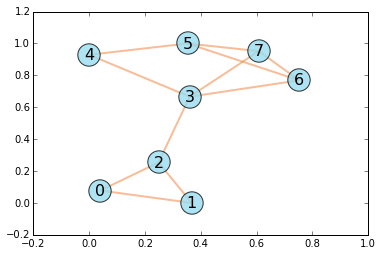

In [28]:
draw(G)

In [29]:
# 分群
partition = community.best_partition(G)
print(partition)

{'1': 0, '0': 0, '3': 1, '2': 0, '5': 1, '4': 1, '7': 1, '6': 1}


In [31]:
# Label Propagation community dection
def findMaxNum(List):
    a = {}
    for tmp in List:
        if a.has_key(tmp):
            a[tmp]+=1
        else:
            a[tmp]=1
    for key, value in a.iteritems():
        if value == sorted(a.values(),reverse=True)[0]:
            return key

# 初始化 label
for node in G.nodes():
    G.node[node]['id']= int(node)

# 分配最高的label
for time in range(20):
    for node in G.nodes():
        tmp = []
        for neighborNode in G.neighbors(node):
            tmp.append(G.node[neighborNode]['id'])
        label = findMaxNum(tmp)
        G.node[node]['id'] = label
        
for node in G.nodes():
    print(node+':'+str(G.node[node]['id']))

1:0
0:0
3:2
2:0
5:2
4:2
7:2
6:2


In [32]:
clusters = {}
for key, value in partition.iteritems():
    if not clusters.has_key(value):
        clusters[value] = [key]
    else:
        clusters[value].append(key)
print(clusters)  

subClustersList = []   
for subKey in range(len(clusters.keys())):
    subCluster = G.subgraph(clusters[subKey])
    subClustersList.append(subCluster)
print(subClustersList)

{0: ['1', '0', '2'], 1: ['3', '5', '4', '7', '6']}
[<networkx.classes.graph.Graph object at 0x1076cdb90>, <networkx.classes.graph.Graph object at 0x107101450>]


In [33]:
# simrank
def simrank(G, r=0.9, max_iter=100, eps=1e-4):
    nodes = G.nodes()
    nodes_i = {k: v for(k, v) in [(nodes[i], i) for i in range(0, len(nodes))]}
    sim_prev = np.zeros(len(nodes))
    sim = np.identity(len(nodes))
    for i in range(max_iter):
        if np.allclose(sim, sim_prev, atol=eps):
            break
        sim_prev = np.copy(sim)
        for u, v in itertools.product(nodes, nodes):
            if u is v:
                continue
            u_ns, v_ns = G.neighbors(u), G.neighbors(v)
            s_uv = sum([sim_prev[nodes_i[u_n]][nodes_i[v_n]] for u_n, v_n in itertools.product(u_ns, v_ns)])
            sim[nodes_i[u]][nodes_i[v]] = (r * s_uv) / (len(u_ns) * len(v_ns))
    return sim

In [34]:
# Cosine Similarity 
def cosSim(a,b):
    cos = float(np.inner(a,b))/(np.linalg.norm(a)*np.linalg.norm(b))
    norCos = 0.5+0.5*cos
    return norCos

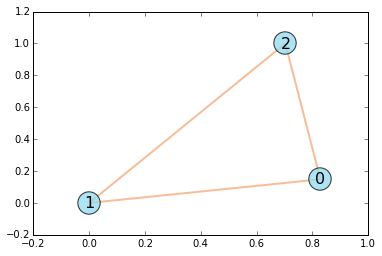

In [35]:
draw(subClustersList[0])

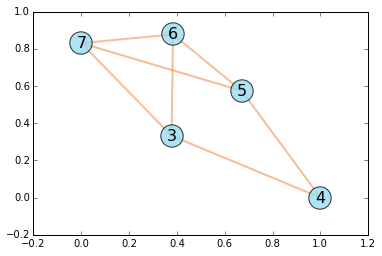

In [36]:
draw(subClustersList[1])

In [37]:
# 各自cluster 算出 Similarity 存入 subSimilaritys
subSimilaritys = []   
for num in range(len(subClustersList)):
    subSimilaritys.append(simrank(subClustersList[num]))
print(subSimilaritys)

[array([[ 1.        ,  0.69212752,  0.69212752],
       [ 0.69212752,  1.        ,  0.69212752],
       [ 0.69212752,  0.69212752,  1.        ]]), array([[ 1.        ,  0.68858127,  0.45517566,  0.5311563 ,  0.5311563 ],
       [ 0.68858127,  1.        ,  0.45517566,  0.5311563 ,  0.5311563 ],
       [ 0.45517566,  0.45517566,  1.        ,  0.66588905,  0.66588905],
       [ 0.5311563 ,  0.5311563 ,  0.66588905,  1.        ,  0.61126386],
       [ 0.5311563 ,  0.5311563 ,  0.66588905,  0.61126386,  1.        ]])]


In [38]:
# 對該物品算總Similarity  user Similarity(cosine) * clusterSimilarity 
# clusterSimilarity :   同cluster---user Similarity(simrank)
#                     不同cluster---0.1
def userSimRec(itemScore, user, simMethods, item ,alpha,beta):
    # user number : shape(itemScore)[0] item number : shape(itemScore)[1]
    n = np.shape(itemScore)[0]
    simTotal = 0.0; ratSimTotal = 0.0
    for cluster, clusterList in clusters.iteritems():
        if str(user) in clusterList:
            clusterUseris = cluster
            userc = clusterList.index(str(user))
#             print(str(user)+':'+str(clusterUseris))
#             print('@@')
            break
    for u in range(n):
        userItemRating = itemScore[u][item]
        # pass norating item
        if userItemRating == 0 or u == user:
            pass
        else:
            # find same rating item
            boolArray = np.logical_and(itemScore[user][:]> 0,itemScore[u][:] > 0)
            boolArray[item] = False
            if len( np.nonzero(boolArray)[0] ) == 0: 
                similarity = 0
            else: 
                userSim = simMethods(itemScore[user][boolArray],itemScore[u][boolArray])
#                 print(itemScore[user][boolArray])
#                 print(itemScore[u][boolArray])
                for cluster, clusterList in clusters.iteritems():
                    if str(u) in clusterList:
                        clusterUis = cluster
#                         print(str(u)+':'+str(clusterUis))
                        uc = clusterList.index(str(u))
                if clusterUseris == clusterUis:
                    clusterSim = subSimilaritys[clusterUseris][userc][uc]
                else:
                    clusterSim = 0.1
#                 print("user:"+str(u)+"-userItemRating:"+str(userItemRating)+"-item:"+str(item)+"-"+"clusterSim:"+str(clusterSim)+"-"+"userSim:"+str(userSim))
            simTotal += alpha*userSim + beta*clusterSim
            ratSimTotal += (alpha*userSim + beta*clusterSim)*userItemRating
    if simTotal == 0: 
        return 0
    else: 
        return ratSimTotal/simTotal

In [39]:
# 對該user沒評分的物品做推薦 N為列出的item數
def recommend(itemScore, user, N=3, simMethods=cosSim,alpha=1,beta=1):
    #find unrated items 
    unratedItems = np.nonzero(itemScore[user,:] ==0)[0]
    if len(unratedItems) == 0: 
        return 'you rated everything'
    else:
        itemScores = []
        for item in unratedItems:
            estimatedScore = userSimRec(itemScore, user, simMethods, item,alpha,beta)
#             print("item:"+str(item)+"-"+"estimatedScore:"+str(estimatedScore))
            itemScores.append((item, estimatedScore))
            recItem = sorted(itemScores, key=lambda x: x[1], reverse=True)[:N]
        return recItem

In [40]:
def loadItemScore():
    tmp = [[4, 4, 0, 2, 2],
           [4, 0, 2, 0, 3],
           [4, 0, 0, 1, 1],
           [1, 1, 1, 2, 0],
           [2, 2, 4, 0, 0],
           [5, 0, 5, 0, 2],
           [1, 1, 1, 3, 0],
           [0, 1, 3, 0, 1]]
    itemScore = np.array(tmp,dtype=np.float)
    return itemScore

In [41]:
dataSet1 = loadItemScore()

In [42]:
recommend(dataSet1, 7, N=3)

[(0, 2.8398478047076852), (3, 2.0879794330334875)]

In [43]:
def loadItemScore2(userN,itemN):
    tmp2Darray = []
    for user in range(userN):
        tmpList = []
        for num in range(itemN):
            # 更改 no rating的比例 預設20%為0
            if randint(1,5) <= 1:
                tmpList.append(0)
            else:
                tmpList.append(randint(1,5))
        tmp2Darray.append(tmpList)
    itemScore = np.array(tmp2Darray,dtype=np.float)
    return itemScore

In [48]:
dataSet2 = loadItemScore2(8,1000)

In [49]:
recommend(dataSet2, 1, N=10 ,alpha=1,beta=0)

[(92, 4.6660271368412216),
 (729, 4.3995425075476815),
 (675, 4.3331620059370675),
 (879, 4.3331608013833058),
 (896, 4.1999341916093185),
 (731, 4.1990684601695083),
 (927, 4.1988958805229633),
 (135, 4.1667188891283846),
 (698, 4.0029111240797484),
 (641, 4.0011513400970076)]

In [50]:
recommend(dataSet2, 1, N=10 ,alpha=0,beta=1)

[(92, 4.8879084017596002),
 (729, 4.7253068040078485),
 (57, 4.6637252052788014),
 (731, 4.6337424053437992),
 (927, 4.6337424053437992),
 (905, 4.5968260225407489),
 (903, 4.4960325281759372),
 (856, 4.4960325281759363),
 (909, 4.4950308026446733),
 (280, 4.4692862831622273)]

In [51]:
recommend(dataSet2, 1, N=10 ,alpha=0.5,beta=0.5)

[(92, 4.7207018334390893),
 (729, 4.4626098714366611),
 (731, 4.2832422692615841),
 (927, 4.2830813616046424),
 (675, 4.278687116080869),
 (135, 4.2212231281329293),
 (879, 4.2145760753431398),
 (57, 4.1622740576760568),
 (905, 4.1270294601280879),
 (111, 4.1119881976206685)]

In [55]:
# load real dataSet
# https://snap.stanford.edu/data/egonets-Facebook.html
edges=[]
nodes=[]
with open ('/Users/wy/Desktop/facebook_combined.txt','r') as f:
    lines = f.readlines()
    for line in lines:
        line = line.strip()   
        line = line.split(' ')
        edges.append((line[0],line[1]))
        nodes.append(line[0])
        nodes.append(line[1])
nodes = set(nodes)

In [56]:
G=nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
print(len(G.nodes()))
print(len(G.edges()))

4039
88234


In [57]:
# 分群
partition = community.best_partition(G)

In [58]:
clusters = {}
for key, value in partition.iteritems():
    if not clusters.has_key(value):
        clusters[value] = [key]
    else:
        clusters[value].append(key)
        
subClustersList = []   
for subKey in range(len(clusters.keys())):
    subCluster = G.subgraph(clusters[subKey])
    subClustersList.append(subCluster)

In [59]:
# 稍微看一下 cluster 分配的 user數
for key, value in clusters.iteritems():
    print(str(key)+':'+str(len(value)))

0:548
1:60
2:514
3:60
4:206
5:341
6:310
7:391
8:423
9:237
10:549
11:73
12:19
13:226
14:38
15:25
16:19


In [60]:
fbDataSet2 = loadItemScore2(4039,1000)

In [61]:
import datetime

In [62]:
# there will run 14hr

# st = datetime.datetime.now()
# # 各自cluster 算出 Similarity 存入 subSimilaritys
# subSimilaritys = []   
# for num in range(len(subClustersList)):
#     subSimilaritys.append(simrank(subClustersList[num]))
# end = datetime.datetime.now()

# runtime = end - st
# print(runtime)

In [63]:
#recommend(fbDataSet2, 1, N=10 ,alpha=1,beta=0)

In [64]:
#recommend(fbDataSet2, 1, N=10 ,alpha=0,beta=1)

In [65]:
#recommend(fbDataSet2, 1, N=10 ,alpha=0.5,beta=0.5)